In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score
import gc

pd.set_option('display.max_columns', None)

In [4]:
valid_data = pd.read_csv('/content/drive/MyDrive/Taobao/valid_data_10_percent.csv')

In [5]:
num_train = len(valid_data[valid_data['userid']<=valid_data.loc[int(0.8*len(valid_data))]['userid']])
num_train

1758557

In [6]:
# numerics = ['price']  

numerics = ['price', 
       'num_show_last_hour_user_adgroup', 'num_click_last_hour_user_adgroup',
       'num_show_last_day_user_adgroup', 'num_click_last_day_user_adgroup',
       'num_show_last_hour_user_cate', 'num_click_last_hour_user_cate',
       'num_show_last_day_user_cate', 'num_click_last_day_user_cate',
       'num_show_last_hour_user_customer', 'num_click_last_hour_user_customer',
       'num_show_last_day_user_customer', 'num_click_last_day_user_customer',
       'num_show_last_hour_user_brand', 'num_click_last_hour_user_brand',
       'num_show_last_day_user_brand', 'num_click_last_day_user_brand',
       'num_show_last_hour_user_all', 'num_click_last_hour_user_all',
       'num_show_last_day_user_all', 'num_click_last_day_user_all',
       'num_show_last_hour_all_adgroup', 'num_click_last_hour_all_adgroup',
       'num_show_last_hour_all_cate', 'num_click_last_hour_all_cate',
       'num_show_last_hour_all_customer', 'num_click_last_hour_all_customer',
       'num_show_last_hour_all_brand', 'num_click_last_hour_all_brand'
       ]  

categories = ['cate_id','customer', 'brand', 'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level',
              'pvalue_level', 'shopping_level', 'occupation', 'new_user_class_level','hour','weekday']

target = 'clk'
valid_cols = numerics + categories + [target]

In [7]:
valid_data = valid_data[valid_cols]

for col in numerics:
  valid_data[col].fillna(0, inplace=True)
  # valid_data[col] = pd.qcut(valid_data[col], 20, labels=False, duplicates = "drop")

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [8]:
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in categories:
  print(feat)
  lbe = LabelEncoder()
  valid_data[feat] = lbe.fit_transform(valid_data[feat].astype(str))
  
mms = MinMaxScaler(feature_range=(0, 1))
valid_data[numerics] = mms.fit_transform(valid_data[numerics])

cate_id
customer
brand
cms_segid
cms_group_id
final_gender_code
age_level
pvalue_level
shopping_level
occupation
new_user_class_level
hour
weekday


In [9]:
# 3.generate input data for model
tmp = valid_data.loc[:int(num_train)]
train, val = train_test_split(tmp, test_size=0.2, random_state=123)

In [10]:
feature_names = numerics + categories

In [11]:
X_train = train[feature_names]
y_train = train[target].values
X_val = val[feature_names]
y_val = val[target].values
# X_train_val = tmp[feature_names]
# y_train_val = tmp[target].values

In [34]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0, sampling_strategy=0.1)
# cc = ClusterCentroids(random_state=0)
# smo = SMOTENC(categorical_features = list(range(0,len(categories))), random_state=0, sampling_strategy=0.2,k_neighbors=3,n_jobs=-1)
X_train_sample, y_train_sample = rus.fit_resample(X_train, y_train)

In [13]:
from scipy import special, optimize
class FocalLoss:

    def __init__(self, gamma, alpha=None):

        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better


In [35]:
fl = FocalLoss(alpha=0.25, gamma=2)

train_input = lgb.Dataset(data=X_train_sample, label=y_train_sample, categorical_feature=categories)
# train_input = lgb.Dataset(data=X_train, label=y_train, categorical_feature=categories)
val_input = lgb.Dataset(data=X_val, label=y_val, categorical_feature=categories)

params = {
    'objective':'binary',
    'metric':{'auc'},
    'num_iterations':300,
    'early_stopping_round':10,
    'learning_rate':0.1,

    'max_depth': 8,
    'num_leaves': 80,

    'subsample':0.8,
    'colsample_bytree':0.4,

    'lambda_l1':0.1,
    'lambda_l2':0.1,

    'verbosity':1,
    'seed': 123,
}

# model = lgb.train(params, train_input, valid_sets=[val_input])
model = lgb.train(params, train_input, valid_sets=[val_input], fobj=fl.lgb_obj)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's auc: 0.585756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.59677
[3]	valid_0's auc: 0.597195
[4]	valid_0's auc: 0.599628
[5]	valid_0's auc: 0.599635
[6]	valid_0's auc: 0.600154
[7]	valid_0's auc: 0.601734
[8]	valid_0's auc: 0.602448
[9]	valid_0's auc: 0.601789
[10]	valid_0's auc: 0.601459
[11]	valid_0's auc: 0.600857
[12]	valid_0's auc: 0.60112
[13]	valid_0's auc: 0.601191
[14]	valid_0's auc: 0.603105
[15]	valid_0's auc: 0.602802
[16]	valid_0's auc: 0.601712
[17]	valid_0's auc: 0.60167
[18]	valid_0's auc: 0.603145
[19]	valid_0's auc: 0.605414
[20]	valid_0's auc: 0.606333
[21]	valid_0's auc: 0.606859
[22]	valid_0's auc: 0.606881
[23]	valid_0's auc: 0.606282
[24]	valid_0's auc: 0.605469
[25]	valid_0's auc: 0.604782
[26]	valid_0's auc: 0.605734
[27]	valid_0's auc: 0.605731
[28]	valid_0's auc: 0.605679
[29]	valid_0's auc: 0.605151
[30]	valid_0's auc: 0.607673
[31]	valid_0's auc: 0.608904
[32]	valid_0's auc: 0.6089
[33]	valid_0's auc: 0.60

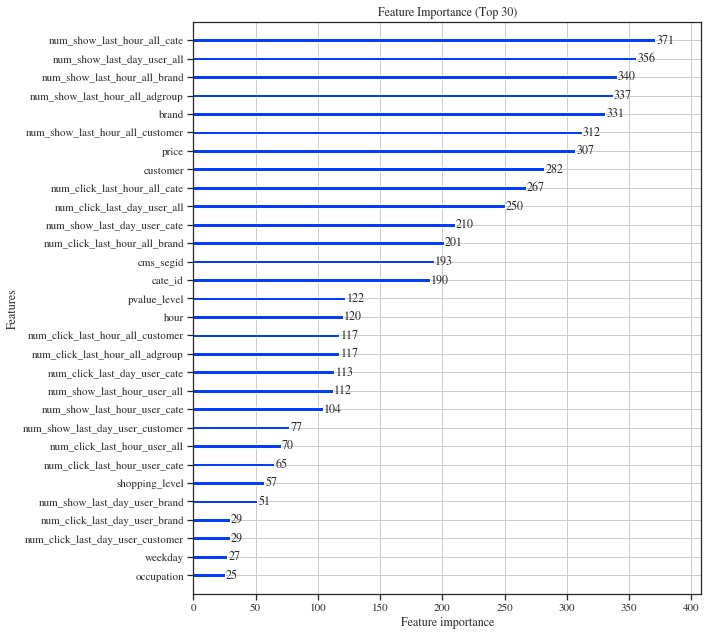

In [44]:
import matplotlib
import seaborn as sns

sns.set(style='ticks')
sns.set_palette("bright")

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams["figure.figsize"] = (10, 9)
lgb.plot_importance(model, max_num_features=30)
plt.title("Feature Importance (Top 30)")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Taobao/plot/feature_importance_30.pdf')

In [16]:
test = valid_data.loc[int(num_train):]
X_test = test[feature_names]
y_test = test[target].values

In [36]:
pred_ans = model.predict(X_test, num_iteration=model.best_iteration)

print("test AUC", round(roc_auc_score(y_test, pred_ans), 4))
print("test Logloss", round(log_loss(y_test, pred_ans), 4))

test AUC 0.609
test Logloss 1.7646


In [37]:
pd.DataFrame(pred_ans).to_csv('/content/drive/MyDrive/Taobao/gbm_focal_rus_10.csv',index=False,header=None)